In [ ]:
import numpy as np
from numba import njit

EPS = 1e-8


@njit
def box2corners(x: float, y: float, w: float, h: float, angle: float) -> np.ndarray:
    """
    中心(x, y), 幅 w, 高さ h, 回転角 angle を持つ矩形(回転BB)の4頂点を計算して返す関数。
    回転行列を用い、回転前の頂点を回転変換する。戻り値は形状 (4, 2) の配列。
    """
    # (0.5, -0.5)などで、中心から矩形の四隅までの相対オフセットを定義
    dx = np.array([0.5, -0.5, -0.5, 0.5]) * w
    dy = np.array([0.5, 0.5, -0.5, -0.5]) * h

    c = np.cos(angle)
    s = np.sin(angle)

    corners = np.empty((4, 2), dtype=np.float64)
    for i in range(4):
        # 回転行列 (cos -sin; sin cos) を用いて各頂点を変換
        rx = c * dx[i] - s * dy[i]
        ry = s * dx[i] + c * dy[i]
        # 中心 (x, y) を加えて最終的な頂点座標を算出
        corners[i, 0] = x + rx
        corners[i, 1] = y + ry
    return corners


@njit
def line_seg_intersection(p1: np.ndarray, p2: np.ndarray) -> np.ndarray:
    """
    2本の線分 p1, p2 (それぞれ始点と終点の座標を持つ2x2配列) が交差するか判定し、
    交点があればその座標を返す。なければ空配列を返す。

    与えられた2つの線分 \( P_1P_2 \) と \( P_3P_4 \) に対して、交点 \( I \) を求める手順は以下の通り（以下chatgpt補完）:
    1. **ベクトルの計算**：
    \[
    \mathbf{r} = P_2 - P_1 = (x_2 - x_1, \; y_2 - y_1) \\
    \mathbf{s} = P_4 - P_3 = (x_4 - x_3, \; y_4 - y_3)
    \]

    2. **外積（分母）の計算**：
    \[
    \text{denom} = \mathbf{r} \times \mathbf{s} = (x_2 - x_1)(y_4 - y_3) - (y_2 - y_1)(x_4 - x_3)
    \]
    - **分母が0の場合**: 線分は平行または重なっている。

    3. **パラメータ \( t \) と \( u \) の計算**：
    \[
    t = \frac{(x_3 - x_1)(y_4 - y_3) - (y_3 - y_1)(x_4 - x_3)}{\text{denom}} \\
    u = \frac{(x_3 - x_1)(y_2 - y_1) - (y_3 - y_1)(x_2 - x_1)}{\text{denom}}
    \]

    4. **交点の存在確認**：
    \[
    0 \leq t \leq 1 \quad \text{かつ} \quad 0 \leq u \leq 1
    \]

    5. **交点の計算**：
    \[
    I = P_1 + t \mathbf{r} = (x_1 + t (x_2 - x_1), \; y_1 + t (y_2 - y_1))
    \]
    """
    x1, y1 = p1[0, 0], p1[0, 1]
    x2, y2 = p1[1, 0], p1[1, 1]
    x3, y3 = p2[0, 0], p2[0, 1]
    x4, y4 = p2[1, 0], p2[1, 1]

    # 2直線のパラメータ方程式の分母 (外積) を計算
    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if np.abs(denom) < EPS:
        # 分母がほぼ0 → 平行 or 重なり → 交点なし扱い
        return np.empty((0, 2), dtype=np.float64)

    # パラメータ t, u を算出し、線分範囲内(0～1)かをチェック
    t = ((x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)) / denom
    u = -((x1 - x2) * (y1 - y3) - (y1 - y2) * (x1 - x3)) / denom
    if t < 0.0 or t > 1.0 or u < 0.0 or u > 1.0:
        return np.empty((0, 2), dtype=np.float64)

    # 線分上に交点がある場合、その座標を返す
    inter_x = x1 + t * (x2 - x1)
    inter_y = y1 + t * (y2 - y1)
    return np.array([[inter_x, inter_y]], dtype=np.float64)


@njit
def point_in_box(pt: np.ndarray, corners: np.ndarray) -> bool:
    """
    pt(点) が、与えられた回転矩形 corners の内部にあるか否かを判定する。いわゆる多角形の点包含判定。
    ベクトルの内積を用いた射影チェックにより内外を判別。真なら内部。
    """
    # 矩形の頂点(以下 0,1,3番目を取り出し、ベクトルAB, ADを作成)
    Ax, Ay = corners[0, 0], corners[0, 1]
    Bx, By = corners[1, 0], corners[1, 1]
    Dx, Dy = corners[3, 0], corners[3, 1]

    # AB, AD, AM(=pt - A) のベクトル
    ABx, ABy = Bx - Ax, By - Ay
    ADx, ADy = Dx - Ax, Dy - Ay
    AMx, AMy = pt[0] - Ax, pt[1] - Ay

    # dotAB: AB と AM の内積, dotAB_AB: AB 同士の内積(=|AB|^2)
    dotAB = ABx * AMx + ABy * AMy
    dotAB_AB = ABx * ABx + ABy * ABy

    # 同様にADベクトルとの内積
    dotAD = ADx * AMx + ADy * AMy
    dotAD_AD = ADx * ADx + ADy * ADy

    # 内積の値が 0～|AB|^2, 0～|AD|^2 の範囲にあるかチェック
    # 範囲外なら四辺形の外部 or 辺上よりも外側
    if dotAB < -EPS or dotAB > dotAB_AB + EPS:
        return False
    if dotAD < -EPS or dotAD > dotAD_AD + EPS:
        return False
    return True


@njit
def intersection_polygon(corners1: np.ndarray, corners2: np.ndarray) -> np.ndarray:
    """
    2つの回転矩形 corners1, corners2 の交差多角形を求める。
    辺同士の交点と、一方の頂点が他方の矩形に含まれるかを確認し、頂点群を得る。
    重複を除去して交差領域を表す多角形の頂点リストを返す。
    """
    pts = []

    # 1) 辺同士の交点探索 (各4辺の全組み合わせ)
    for i in range(4):
        seg1 = np.zeros((2, 2), dtype=np.float64)
        seg1[0] = corners1[i]
        seg1[1] = corners1[(i + 1) % 4]

        for j in range(4):
            seg2 = np.zeros((2, 2), dtype=np.float64)
            seg2[0] = corners2[j]
            seg2[1] = corners2[(j + 1) % 4]
            inter = line_seg_intersection(seg1, seg2)
            if inter.shape[0] > 0:  # 交点がある場合
                pts.append((inter[0, 0], inter[0, 1]))

    # 2) corners1の頂点が、corners2に包含されるか
    for i in range(4):
        if point_in_box(corners1[i], corners2):
            pts.append((corners1[i, 0], corners1[i, 1]))

    # 3) corners2の頂点が、corners1に包含されるか
    for j in range(4):
        if point_in_box(corners2[j], corners1):
            pts.append((corners2[j, 0], corners2[j, 1]))

    # 4) 重複頂点の除去 (数値誤差を考慮し EPS 以下なら同一点とみなす)
    unique_pts = []
    for p in pts:
        is_duplicate = False
        for q in unique_pts:
            if abs(p[0] - q[0]) < EPS and abs(p[1] - q[1]) < EPS:
                is_duplicate = True
                break
        if not is_duplicate:
            unique_pts.append(p)

    # 結果の頂点が空の場合は空配列を返す
    if not unique_pts:
        return np.empty((0, 2), dtype=np.float64)
    return np.array(unique_pts, dtype=np.float64)


@njit
def polygon_area(points: np.ndarray) -> float:
    """
    先に計算した交差多角形の（points が示す頂点リスト）の面積を
    shoelace formula (靴紐公式) に基づいて計算。
    ただし、頂点を重心まわりに並び替えてからshoelace formulaを適用。

    交差多角形は、凸多角形である矩形２つの交差部分に対応しているが、 凸集合の交差は凸である。
    以下に行う手続のアイデアは凸包の頂点取得や凸多角形の面積計算で記述ができる。
    """
    n = points.shape[0]
    if n < 3:
        return 0.0  # 3頂点未満は面積ゼロ

    # 頂点の重心を計算
    cx = np.sum(points[:, 0]) / n
    cy = np.sum(points[:, 1]) / n

    # 重心を原点とみなし、角度でソート
    shifted = points.copy()
    shifted[:, 0] -= cx
    shifted[:, 1] -= cy
    angles = np.arctan2(shifted[:, 1], shifted[:, 0])
    order = np.argsort(angles)
    sorted_pts = shifted[order]

    # shoelace formulaで面積計算
    area_val = 0.0
    for i in range(n):
        x1, y1 = sorted_pts[i]
        x2, y2 = sorted_pts[(i + 1) % n]
        area_val += x1 * y2 - x2 * y1
    return abs(area_val) * 0.5


@njit
def rotated_iou(box1: np.ndarray, box2: np.ndarray) -> float:
    """
    box1, box2: [x, y, w, h, angle] 形式の回転矩形2つについて、
    それらの交差多角形の面積 / (面積の和 - 交差面積) として IoU を返す。
    """
    c1 = box2corners(box1[0], box1[1], box1[2], box1[3], box1[4])
    c2 = box2corners(box2[0], box2[1], box2[2], box2[3], box2[4])

    inter_pts = intersection_polygon(c1, c2)
    inter_area = polygon_area(inter_pts)

    area1 = box1[2] * box1[3]
    area2 = box2[2] * box2[3]

    union = area1 + area2 - inter_area
    if union < EPS:
        return 0.0
    return inter_area / union

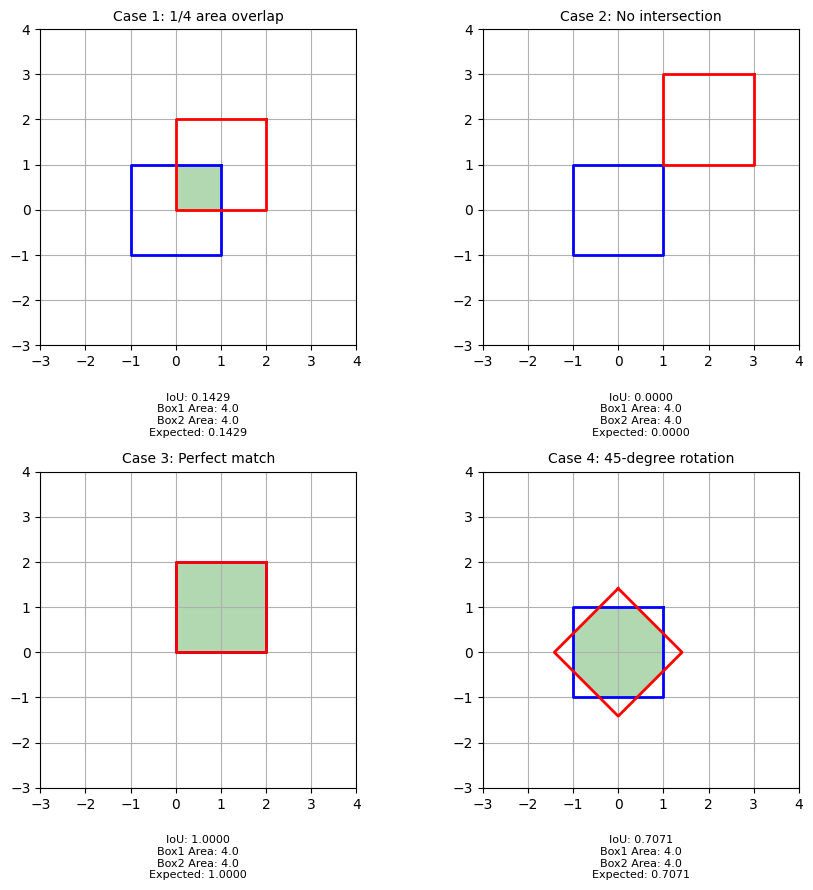

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


plt.figure(figsize=(9, 9))
gs = GridSpec(2, 2)
cases = [
    {
        "title": "Case 1: 1/4 area overlap",
        "box1": np.array([0.0, 0.0, 2.0, 2.0, 0.0]),  # (x, y, w, h, angle)
        "box2": np.array([1.0, 1.0, 2.0, 2.0, 0.0]),
        "expected_iou": 1 / (4 + 4 - 1),  # 1/7 ≈ 0.1429
    },
    {
        "title": "Case 2: No intersection",
        "box1": np.array([0.0, 0.0, 2.0, 2.0, 0.0]),
        "box2": np.array([2.0, 2.0, 2.0, 2.0, 0.0]),
        "expected_iou": 0.0,
    },
    {
        "title": "Case 3: Perfect match",
        "box1": np.array([1.0, 1.0, 2.0, 2.0, 0.0]),
        "box2": np.array([1.0, 1.0, 2.0, 2.0, 0.0]),
        "expected_iou": 1.0,
    },
    {
        "title": "Case 4: 45-degree rotation",
        "box1": np.array([0.0, 0.0, 2.0, 2.0, 0.0]),
        "box2": np.array([0.0, 0.0, 2.0, 2.0, np.pi / 4]),
        # 例えば下の記事に近い形で正八角形の面積を手計算で導出できる。八角形の面積が求まればIoUも求まる。
        # https://www.algebra.com/algebra/homework/Surface-area/Surface-area.faq.question.1116886.html
        "expected_iou": 1 / np.sqrt(2),
    },
]

for i, case in enumerate(cases):
    ax = plt.subplot(gs[i])
    box1 = case["box1"]
    box2 = case["box2"]

    # 矩形の頂点計算
    corners1 = box2corners(*box1)
    corners2 = box2corners(*box2)

    # 交差多角形とIoU計算
    inter_pts = intersection_polygon(corners1, corners2)
    inter_area = polygon_area(inter_pts)
    iou_val = rotated_iou(box1, box2)

    # プロット設定
    ax.set_title(case["title"], fontsize=10)
    ax.set_xlim(-3, 4)
    ax.set_ylim(-3, 4)

    # 矩形1の描画（青）
    xs1 = np.append(corners1[:, 0], corners1[0, 0])
    ys1 = np.append(corners1[:, 1], corners1[0, 1])
    ax.plot(xs1, ys1, "b-", linewidth=2)

    # 矩形2の描画（赤）
    xs2 = np.append(corners2[:, 0], corners2[0, 0])
    ys2 = np.append(corners2[:, 1], corners2[0, 1])
    ax.plot(xs2, ys2, "r-", linewidth=2)

    # 交差領域の塗りつぶし（緑）
    if inter_pts.shape[0] >= 3:
        cx = np.mean(inter_pts[:, 0])
        cy = np.mean(inter_pts[:, 1])
        angles = np.arctan2(inter_pts[:, 1] - cy, inter_pts[:, 0] - cx)
        order = np.argsort(angles)
        sorted_pts = inter_pts[order]
        px = np.append(sorted_pts[:, 0], sorted_pts[0, 0])
        py = np.append(sorted_pts[:, 1], sorted_pts[0, 1])
        ax.fill(px, py, color="g", alpha=0.3)

    # テキスト表示
    area1 = box1[2] * box1[3]
    area2 = box2[2] * box2[3]
    info_text = f"IoU: {iou_val:.4f}\nBox1 Area: {area1}\nBox2 Area: {area2}"
    if case["expected_iou"] != "calculated":
        info_text += f"\nExpected: {case['expected_iou']:.4f}"
    ax.text(0.5, -0.15, info_text, transform=ax.transAxes, ha="center", va="top", fontsize=8)

    ax.grid(True)
    ax.set_aspect("equal")

plt.tight_layout()
plt.show()